In [1]:
import sys
import torch
import warnings
import torchvision
import numpy as np
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as transforms

from scipy.stats import entropy
from torch.autograd import Variable
from torch.nn import functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models.inception import inception_v3

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [2]:
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 30
lrG = 0.0001
lrD = 0.0004
beta1 = 0.5
ngpu = 1

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'sheep', 'truck')

for (images, labels) in dataloader:
    print(images.shape)
    print(labels)
    break

100%|██████████| 170498071/170498071 [00:13<00:00, 12668454.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
torch.Size([128, 3, 64, 64])
tensor([0, 6, 8, 2, 3, 3, 4, 2, 7, 7, 9, 1, 8, 8, 2, 7, 1, 1, 2, 8, 4, 8, 4, 8,
        4, 7, 9, 6, 0, 7, 1, 1, 5, 5, 5, 1, 5, 0, 1, 2, 8, 0, 7, 0, 5, 4, 8, 1,
        9, 5, 9, 4, 6, 4, 4, 0, 0, 5, 1, 4, 6, 1, 0, 0, 4, 5, 7, 9, 4, 2, 9, 4,
        4, 2, 9, 7, 3, 4, 6, 4, 7, 2, 6, 1, 7, 2, 0, 2, 7, 0, 5, 5, 2, 5, 0, 3,
        5, 9, 7, 7, 1, 6, 9, 6, 6, 2, 2, 3, 2, 5, 5, 5, 7, 9, 1, 2, 9, 8, 8, 8,
        2, 9, 7, 7, 6, 3, 0, 5])


In [4]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [5]:
# Discriminator code
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/30][0/391]	Loss_D: 2.1587	Loss_G: 4.0626	D(x): 0.2542	D(G(z)): 0.3519 / 0.0205
[0/30][50/391]	Loss_D: 0.0014	Loss_G: 36.6992	D(x): 0.9986	D(G(z)): 0.0000 / 0.0000
[0/30][100/391]	Loss_D: 0.0005	Loss_G: 36.1645	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[0/30][150/391]	Loss_D: 0.0225	Loss_G: 30.2243	D(x): 0.9891	D(G(z)): 0.0000 / 0.0000
[0/30][200/391]	Loss_D: 0.0178	Loss_G: 11.1466	D(x): 0.9835	D(G(z)): 0.0000 / 0.0001
[0/30][250/391]	Loss_D: 0.0455	Loss_G: 8.9268	D(x): 0.9711	D(G(z)): 0.0051 / 0.0004
[0/30][300/391]	Loss_D: 0.1318	Loss_G: 10.8300	D(x): 0.9975	D(G(z)): 0.0683 / 0.0000
[0/30][350/391]	Loss_D: 0.1238	Loss_G: 4.2133	D(x): 0.9470	D(G(z)): 0.0592 / 0.0225
[1/30][0/391]	Loss_D: 0.0770	Loss_G: 4.8434	D(x): 0.9667	D(G(z)): 0.0379 / 0.0125
[1/30][50/391]	Loss_D: 0.1092	Loss_G: 8.5095	D(x): 0.9684	D(G(z)): 0.0260 / 0.0071
[1/30][100/391]	Loss_D: 0.1010	Loss_G: 7.9566	D(x): 0.9224	D(G(z)): 0.0005 / 0.0006
[1/30][150/391]	Loss_D: 0.0364	Loss_G: 6.1266	D(x):

In [8]:
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

In [10]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=5, repeat_delay=10, blit=True)

HTML(ani.to_jshtml())

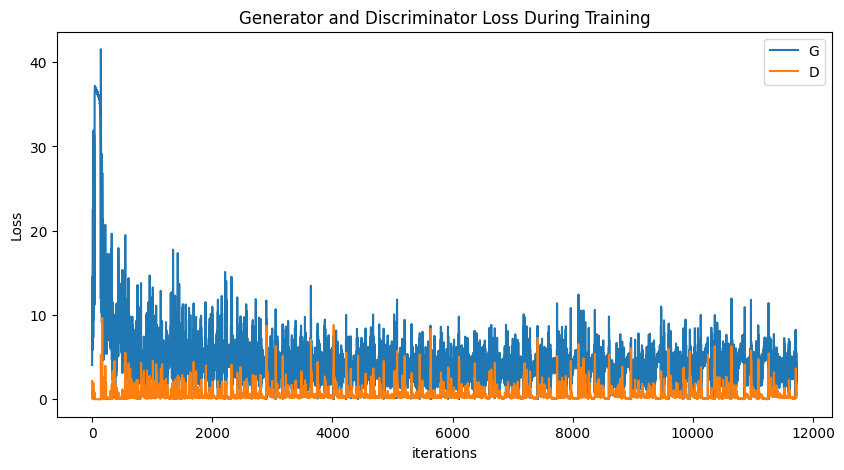

In [11]:
# Plot of Loss vs Epoch curve
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

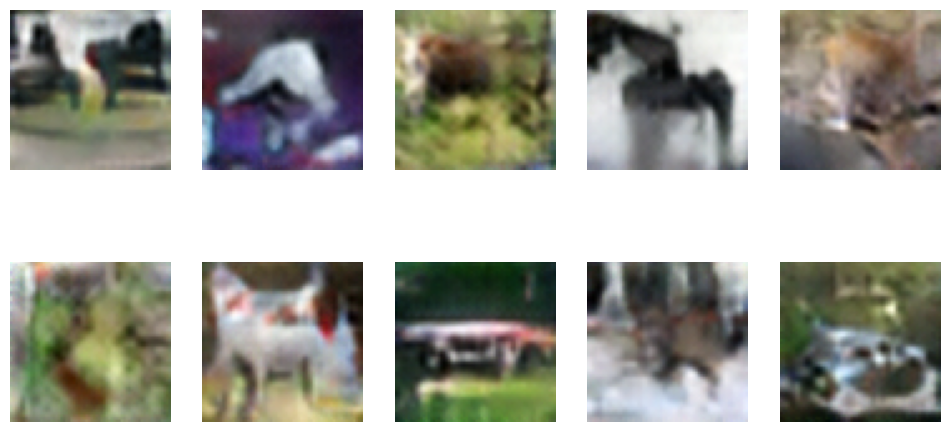

In [12]:
# Generate images from the learned distribution
netG.eval()

num = 10
images = []
with torch.no_grad():
    for i in range(num):
        noise = torch.randn(1, nz, 1, 1, device=device)
        image = netG(noise).detach().cpu()
        images.append(image.squeeze(1))
        vutils.save_image(image, f'image_{i+1}.png', normalize=True)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(num):
    img = plt.imread(f"image_{i+1}.png")
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')
plt.show()

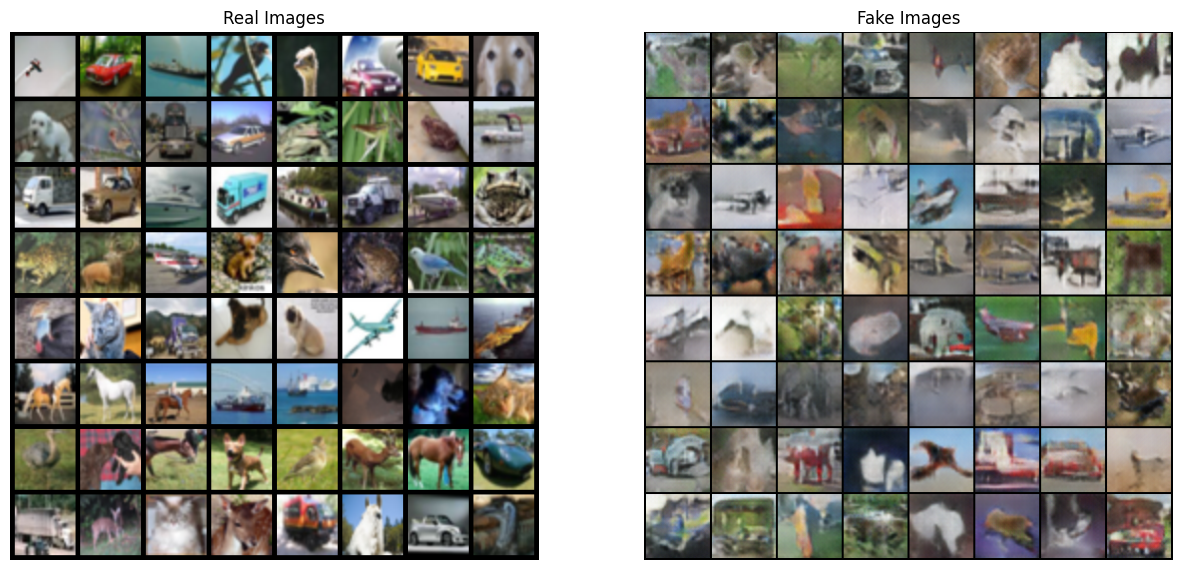

In [13]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [14]:
# Inception score of the generated images
def inception_score(imgs, cuda=True, batch_size=10, resize=False, splits=1):
    N = len(imgs)

    assert batch_size > 0
    assert N == batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    imgs_tensor = torch.cat(imgs, dim=0).type(dtype)
    dataloader = torch.utils.data.DataLoader(imgs_tensor, batch_size=batch_size)

    # Load Inception v3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval()
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)

    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batchv = Variable(batch)

        preds[i * batch_size:i * batch_size + batch_size] = get_pred(batchv)

    # compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

print("Calculating Inception Score...")
print(inception_score(images, cuda=True, batch_size=10, resize=True, splits=1))

Calculating Inception Score...


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 95.3MB/s]


(2.3434585723757055, 0.0)
